連続体方程式（通常は偏微分方程式、PDE）を物理インフォームドニューラルネットワーク（PINNs）の損失関数に組み込む際のプロセスは、モデルが物理的な法則に従う解を学習できるようにするために重要です。以下に、その基本的な手順を説明します。

### 1. 連続体方程式

連続体方程式としてLaplace方程式を考える．これは次のように表される．

$$ ∇^2u(x,t) = 0, $$

ここで、$u(x,t)$は解となる応力を表す。PINNsの損失関数にLaplace方程式の近似を追加する．


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## 1. 物体の形状から点群データを作成する
例として、単純な円を作成

<function matplotlib.pyplot.show(close=None, block=None)>

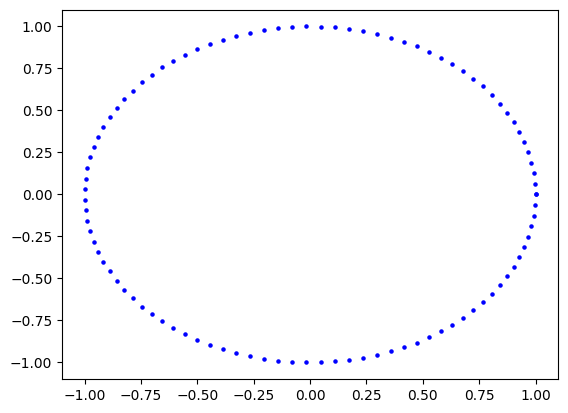

In [3]:
n_points = 100
theta = np.linspace(0, 2 * np.pi, n_points)
x = np.cos(theta)
y = np.sin(theta)
points = np.column_stack((x, y))    # 1次元配列をスタックして2次元配列にする

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(x, y, c="blue", s=5)
plt.show

# 2.PINNsを用いて応力を算出する
簡単なMLPを使用

In [5]:
# 入力点群を標準化
scaler = StandardScaler()                  # scikit-learn の標準化クラスのインスタンス作成
X_scaled = scaler.fit_transform(points)    # 点群を標準化

# 応力予測のMLPモデル定義
class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()            # MLPの親クラスを初期化
    self.fc1 = nn.Linear(2, 10)
    self.fc2 = nn.Linear(10, 10)
    self.fc3 = nn.Linear(10, 1)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = self.fc3(x)
    return x

model = MLP()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 3. **連続体方程式をPINNsの損失関数に組み込む**

In [7]:
def laplace_approximation(X_scaled, model):
  X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
  X_tensor.requires_grad = True
  predicted_stress = model(X_tensor)

  # 1階微分を計算
  first_grad = torch.autograd.grad(predicted_stress.sum(), X_tensor, create_graph=True)[0]

  # 2階微分を計算
  second_grad = torch.autograd.grad(first_grad.sum(), X_tensor, create_graph=True)[0]

  return second_grad

# 4. 各点群の応力を算出する

In [8]:
def calculate_stress(X_scaled, model):
  X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
  predicted_stress = model(X_tensor).detach().numpy()          # detach() : 計算グラフを切り離す

  return predicted_stress

# 5. モデルの学習

In [9]:
model.train()
num_epochs=1000

for epoch in range(num_epochs):

    optimizer.zero_grad()
    gradients = laplace_approximation(X_scaled, model)    # 2回微分を計算
    loss = torch.norm(gradients)                          # 2階微分のL1ノルムを誤差に設定
    loss.backward()                                       # 勾配計算と更新
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.0
Epoch 100, Loss: 0.0
Epoch 200, Loss: 0.0
Epoch 300, Loss: 0.0
Epoch 400, Loss: 0.0
Epoch 500, Loss: 0.0
Epoch 600, Loss: 0.0
Epoch 700, Loss: 0.0
Epoch 800, Loss: 0.0
Epoch 900, Loss: 0.0


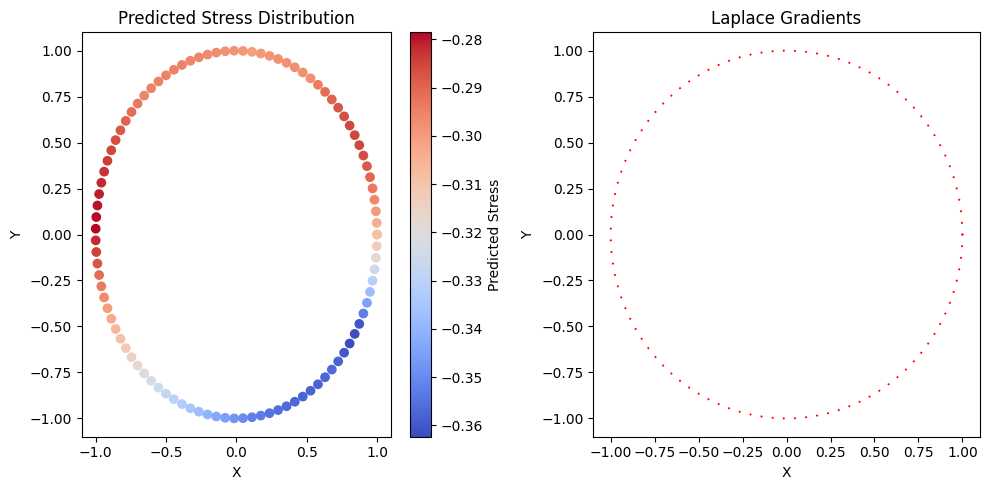

In [12]:
predicted_stress = calculate_stress(X_scaled, model)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(x, y, c=predicted_stress, cmap='coolwarm')
plt.colorbar(label = 'Predicted Stress')
plt.title('Predicted Stress Distribution')
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(1, 2, 2)
plt.quiver(x, y, gradients[:, 0].detach().numpy(), gradients[:, 1].detach().numpy(), scale=10, color='r')
plt.title('Laplace Gradients')
plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.show()



X= (100, 100)
[[ 0.         0.1010101  0.2020202 ...  9.7979798  9.8989899 10.       ]
 [ 0.         0.1010101  0.2020202 ...  9.7979798  9.8989899 10.       ]
 [ 0.         0.1010101  0.2020202 ...  9.7979798  9.8989899 10.       ]
 ...
 [ 0.         0.1010101  0.2020202 ...  9.7979798  9.8989899 10.       ]
 [ 0.         0.1010101  0.2020202 ...  9.7979798  9.8989899 10.       ]
 [ 0.         0.1010101  0.2020202 ...  9.7979798  9.8989899 10.       ]]
Y= (100, 100)
[[ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.1010101  0.1010101  0.1010101 ...  0.1010101  0.1010101  0.1010101]
 [ 0.2020202  0.2020202  0.2020202 ...  0.2020202  0.2020202  0.2020202]
 ...
 [ 9.7979798  9.7979798  9.7979798 ...  9.7979798  9.7979798  9.7979798]
 [ 9.8989899  9.8989899  9.8989899 ...  9.8989899  9.8989899  9.8989899]
 [10.        10.        10.        ... 10.        10.        10.       ]]
Z= (100, 100)


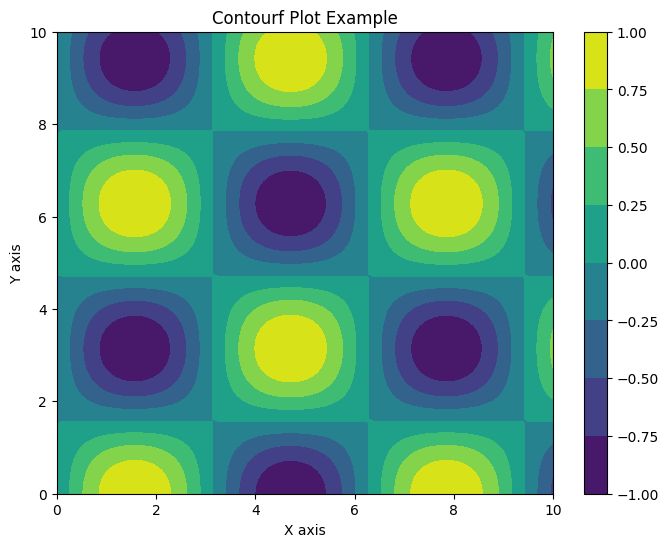

In [ ]:
# meshgridの動き確認
# データの準備
x = np.linspace(0, 10, 100)  # x 軸の範囲
y = np.linspace(0, 10, 100)  # y 軸の範囲
X, Y = np.meshgrid(x, y)     # グリッドの生成
Z = np.sin(X) * np.cos(Y)    # Z 値の計算

print('X=',X.shape) # 行方向が同じ値
print(X)
print('Y=',Y.shape) # 列方向が同じ値
print(Y)
print('Z=',Z.shape)

# プロット
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, Z, cmap='viridis')  # 塗りつぶし等高線プロット
plt.colorbar(contour)  # カラーバーの追加
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.title('Contourf Plot Example')
plt.show()
